# Introduction

1. Compare wine score to median score for that price range.
2. Create value for money index (divide scaled points into log of price). Higher values mean better value.
3. Regress price on available predictors. Wines with prices less than what is predicted by the model are better value.

In [216]:
%matplotlib inline

# Change working directory
if 'dir_changed' in locals():
    pass
else:
    os.chdir(os.path.abspath(os.path.join(os.path.dirname(os.path.realpath(sys.argv[1])), os.pardir)))
    dir_changed = False

# Append location of customer modules to path and import modules
sys.path.append('src/custom-modules')
import model_diagnostics

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# from xgboost.sklearn import XGBClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import CountVectorizer

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [217]:
wine = pd.read_csv('data/raw/winemag-data-130k-v2.csv', index_col = 0)

# Wrangling

It would be interesting to look at the year of the wine. While this isn't included as a column in the dataset, we can extract is from the `title` using regex. We will search the titles and find numbers that match years in the 20th and 21st centuries.

In [218]:
# regex to extract date (matching wines from 20th and 21st centuries)
wine['year'] = wine['title'].apply(lambda x: re.search(r'(19|20)[0-9]{2}', x))  # _sre.SRE_Match object returned
year_matched = pd.notnull(wine['year'])  # Find where there is a match (no match signified by `NaN`)
wine.loc[year_matched, 'year'] = wine.loc[year_matched, 'year'].apply(lambda x: x.group(0))  # Extract year where there is a match
wine = wine[~wine['year'].isnull()]  # Drop columns where `year` is null (no match)
wine['year'] = wine['year'].astype(int)

For now, I'll deal with missing values by dropping all rows that contain any.

In [219]:
wine = wine.dropna(axis = 0, how = 'any') 

In [220]:
numeric_cols = wine._get_numeric_data().columns
categoric_cols = [c for c in wine.columns if c not in numeric_cols]

The dataset contains some duplicates. We can go ahead and drop duplicated rows where every column is duplicated. I'll keep the first occurance.

In [221]:
print('Duplicated rows:')
wine.duplicated().value_counts()
wine = wine.drop_duplicates(keep='first')

Duplicated rows:


False    20171
True      1876
dtype: int64

We can see that even though we've dropped rows where *every* column is diplicated, there are cases where the `title` is duplicated but there may be different scores. Which one do we keep? It appears that the duplicates arise where a wine is reviewed more than once. For example, `Ascension Cellars 2015 Silver White (Paso Robles)` appears twice, but the reviews were published in [2016](https://www.winemag.com/buying-guide/bianchi-2012-signature-selection-cabernet-sauvignon-paso-robles/) and [2017](https://www.winemag.com/buying-guide/bianchi-2012-signature-selection-cabernet-sauvignon-paso-robles-253492/), respectively. You can't see that from the data, since publication date isn't included. But I discovered this by going to the [WineEnthusiast](https://www.winemag.com/) website, from which this data were scraped, and searching for the offending reviews.

Since publication date isn't included in the data, we can't distinguish between reviews and there's no systematic way to decide which to keep. I'll keep the first occurance as it appears in the dataset. This solves the duplicating problem but it's worth noting that bias could be introduced here, as we're only keeping one review and there may be some information about wines with multiple reviews that we're missing. However, dropping both reviews where the `title` is duplicated could also introduce bias, since we'd only be looking at the subset of wines that have only one review. A better solution would be to include publication date and either include both reviews or systematically include one (the first or last publication for instance).

In [222]:
wine[wine.duplicated(subset='title', keep=False)].sort_values('title').head()
wine = wine.drop_duplicates(subset='title', keep='first')
print('Duplicated rows:')
wine.duplicated('title').value_counts()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,year
45897,US,"Brown pear, banana and gooey cherimoya aromas ...",Silver,86,36.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Ascension Cellars 2015 Silver White (Paso Robles),Rhône-style White Blend,Ascension Cellars,2015
66781,US,This is a very ripe wine with lots of tropical...,Silver,85,36.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Ascension Cellars 2015 Silver White (Paso Robles),White Blend,Ascension Cellars,2015
13601,US,Fresh-crushed red currant aromas mix with drie...,Signature Selection,87,19.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2012 Signature Selection Cabernet Sauv...,Cabernet Sauvignon,Bianchi,2012
28899,US,"Dried black cherries, dried herbs, pencil shav...",Signature Selection,86,21.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2012 Signature Selection Cabernet Sauv...,Cabernet Sauvignon,Bianchi,2012
52960,US,"A light and very pretty Pinot Noir, Brandborg'...",Bench Lands,87,22.0,Oregon,Umpqua Valley,Southern Oregon,Paul Gregutt,@paulgwine,Brandborg 2007 Bench Lands Pinot Noir (Umpqua ...,Pinot Noir,Brandborg,2007


Duplicated rows:


False    20138
dtype: int64

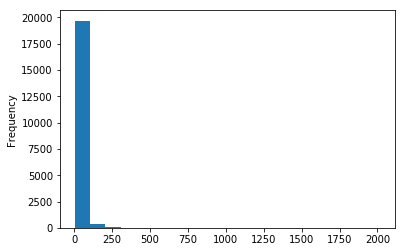

In [223]:
wine['price'].plot.hist(bins=20)

If we log price, we can now see a much more nicely-behaved price distribution. However, there are still some large outliers.

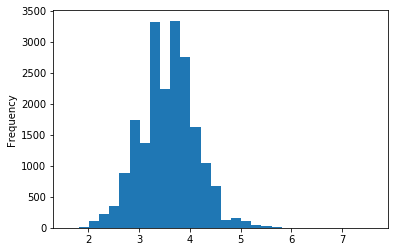

In [224]:
wine['log_price'] = np.log(wine['price'])
wine['log_price'].plot.hist(bins=30)

We can see that there is a very long tail of prices. To make things simpler, let's remove outliers. I'll define these as 1.5 times the inter-quartile range. This removes about 1.4% of the data.

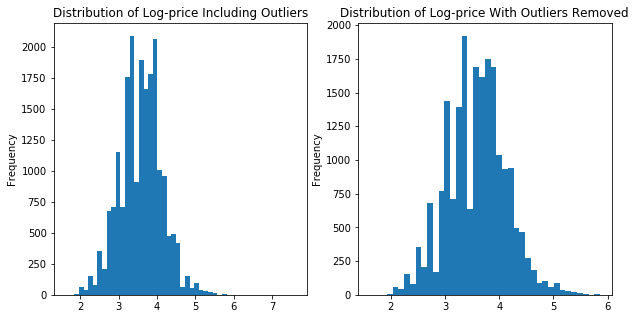

In [232]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
wine['log_price'].plot.hist(bins=50, ax=ax1)
ax1.set_title('Distribution of Log-price Including Outliers')
wine.loc[wine['log_price']<6, 'log_price'].plot.hist(bins=40, ax=ax2)
ax2.set_title('Distribution of Log-price With Outliers Removed')
plt.show();

I'm going to go ahead and remove the outliers. We can see that the mean and mediun are not around the same value of 3.5 and a very balanced boxplot. 

count    20134.000000
mean         3.582591
std          0.541397
min          1.609438
25%          3.218876
50%          3.583519
75%          3.912023
max          5.857933
Name: log_price, dtype: float64

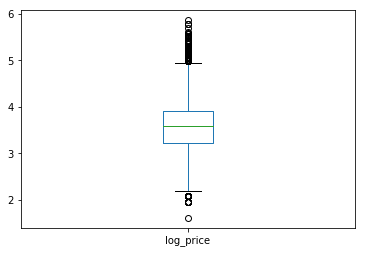

In [234]:
wine = wine.loc[wine['log_price']<6]
wine['log_price'].describe();
wine['log_price'].plot.box()

# Value for money wines

Value for money is difficult to quantify but the simplest way we can look it is a trade-off between 'value' and 'price'. Value is also an iffy concept and is very subjective. In this case, we have `points`, which is also subjective but since these are professional reviewers, I'd like to think that they would at least be a good overall proxy for value. We are also given the price. How do we compare them? Now, the first thing to observe is that more expensive wines tend to have higher points, as illustrated in the boxplots below.

In [282]:
# wine['log_price'].astype(int)
pd.cut(wine['log_price'], np.arange(0, np.ceil(wine['log_price'].max()), 0.5), include_lowest=True)

4         (4.0, 4.5]
10        (2.5, 3.0]
23        (3.0, 3.5]
25        (4.0, 4.5]
35        (3.5, 4.0]
60        (4.5, 5.0]
62        (3.0, 3.5]
64        (3.0, 3.5]
67        (3.5, 4.0]
71        (3.5, 4.0]
73        (4.0, 4.5]
74        (4.0, 4.5]
75        (4.0, 4.5]
78        (3.0, 3.5]
84        (3.0, 3.5]
87        (4.0, 4.5]
90        (3.0, 3.5]
92        (4.0, 4.5]
94        (3.0, 3.5]
99        (4.0, 4.5]
108       (3.0, 3.5]
111       (4.0, 4.5]
114       (2.5, 3.0]
116       (3.0, 3.5]
144       (4.0, 4.5]
145       (4.0, 4.5]
146       (4.0, 4.5]
147       (4.0, 4.5]
149       (3.5, 4.0]
150       (3.0, 3.5]
             ...    
129739    (3.5, 4.0]
129744    (2.5, 3.0]
129746    (4.0, 4.5]
129756    (4.0, 4.5]
129790    (3.5, 4.0]
129815    (2.5, 3.0]
129821    (3.0, 3.5]
129840    (2.5, 3.0]
129854    (3.5, 4.0]
129855    (2.5, 3.0]
129857    (3.5, 4.0]
129861    (3.5, 4.0]
129862    (3.0, 3.5]
129866    (3.5, 4.0]
129867    (4.0, 4.5]
129868    (3.5, 4.0]
129891    (4.

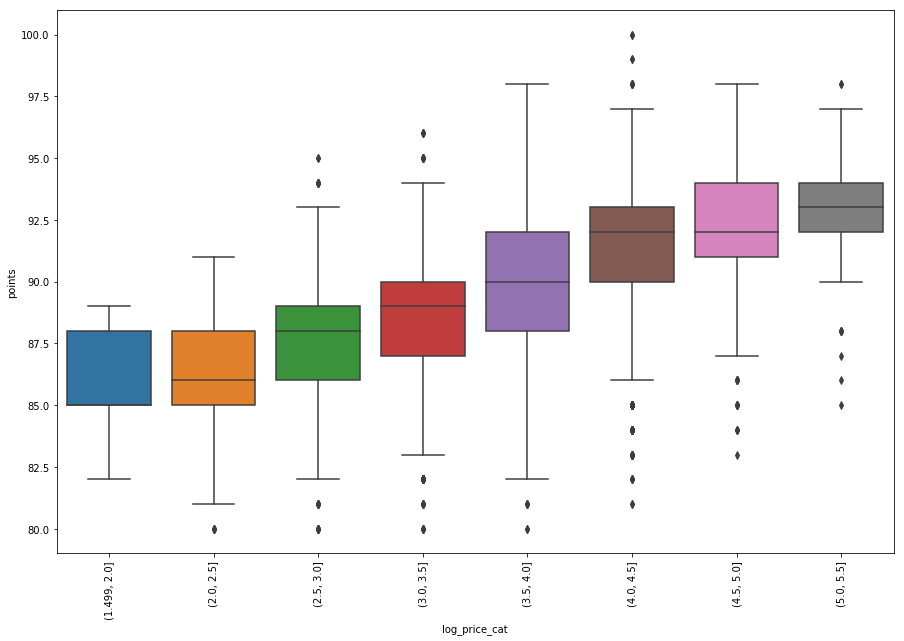

In [285]:
wine['log_price_cat'] = pd.cut(wine['log_price'], np.arange(1.5, np.ceil(wine['log_price'].max()), 0.5), include_lowest=True)
fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['points'], x=wine['log_price_cat'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

# wine['price_cat'] = pd.cut(wine['price'], range(0, wine['price'].max().astype(int), 10), include_lowest=True)
# fig, ax = plt.subplots(figsize = (15, 10))
# s = sns.boxplot(y=wine['points'], x=wine['price_cat'])
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.show();

In [ ]:
## Simple ratio of score to price

One way to think of value for money, is to divide the price of the wine into the score. The higher the ration of score to price, the greater the value for money. We can then figure out what the best value for money wine is by:
+ price range
+ country
+ winery
+ variety

In [29]:
wine['points_per_dollar'] = wine['points']/wine['price'] 

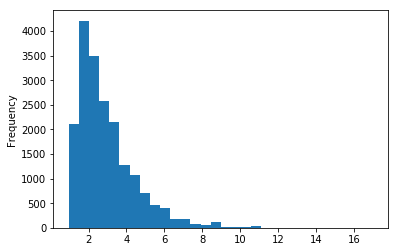

In [30]:
wine['points_per_dollar'].plot.hist(bins=30)

`Points per dollar` has a right-ward skew but looks a lot more normal when logged.

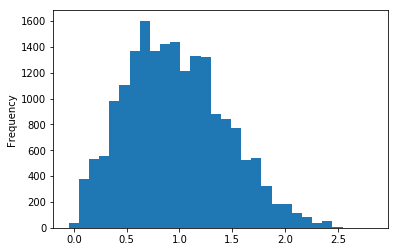

In [31]:
np.log(wine['points_per_dollar']).plot.hist(bins=30)

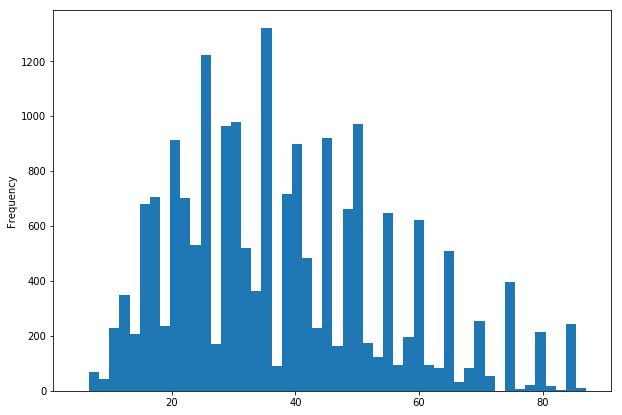

In [32]:
fig, ax = plt.subplots(figsize = (10, 7))
wine['price'].plot.hist(bins=50)

In [212]:
def scale(series):
    return (series - series.min()) / (series.max() - series.min())
wine['scaled_price'] = scale(wine['price'])
wine['scaled_points'] = scale(wine['points'])
wine['scaled_points_per_dollar'] = wine['scaled_points']/wine['scaled_points']

In [213]:
wine['log_price'] = np.log(wine['price'])
wine['log_price_cat'] = wine['log_price'].round()
wine['scaled_points_per_dollar'] = wine['scaled_points']/np.log1p(wine['price'])

In [214]:
wine['price_cat'] = pd.cut(wine['price'], range(wine['price'].min().astype(int), wine['price'].max().astype(int), 5), include_lowest=True)

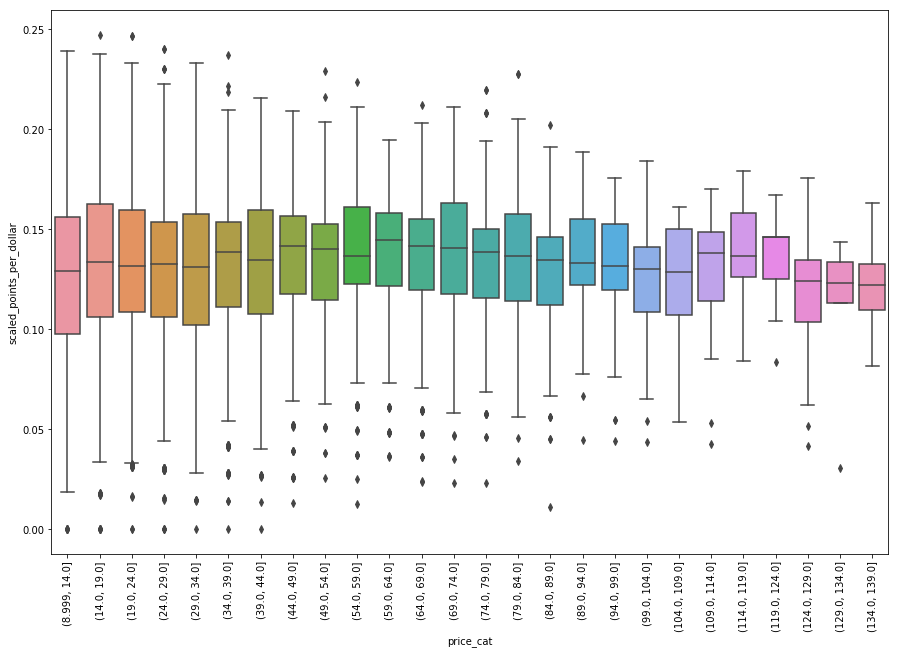

In [215]:
fig, ax = plt.subplots(figsize = (15, 10))
s = sns.boxplot(y=wine['scaled_points_per_dollar'], x=wine['price_cat'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show();

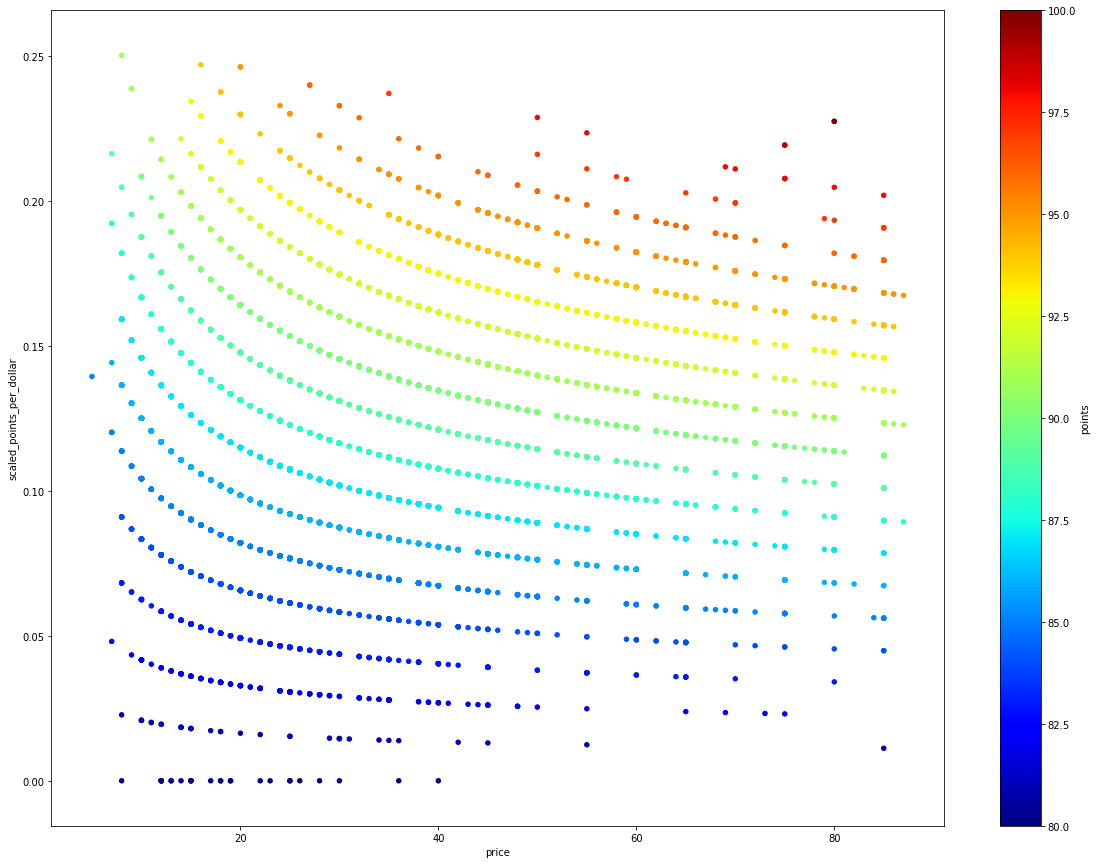

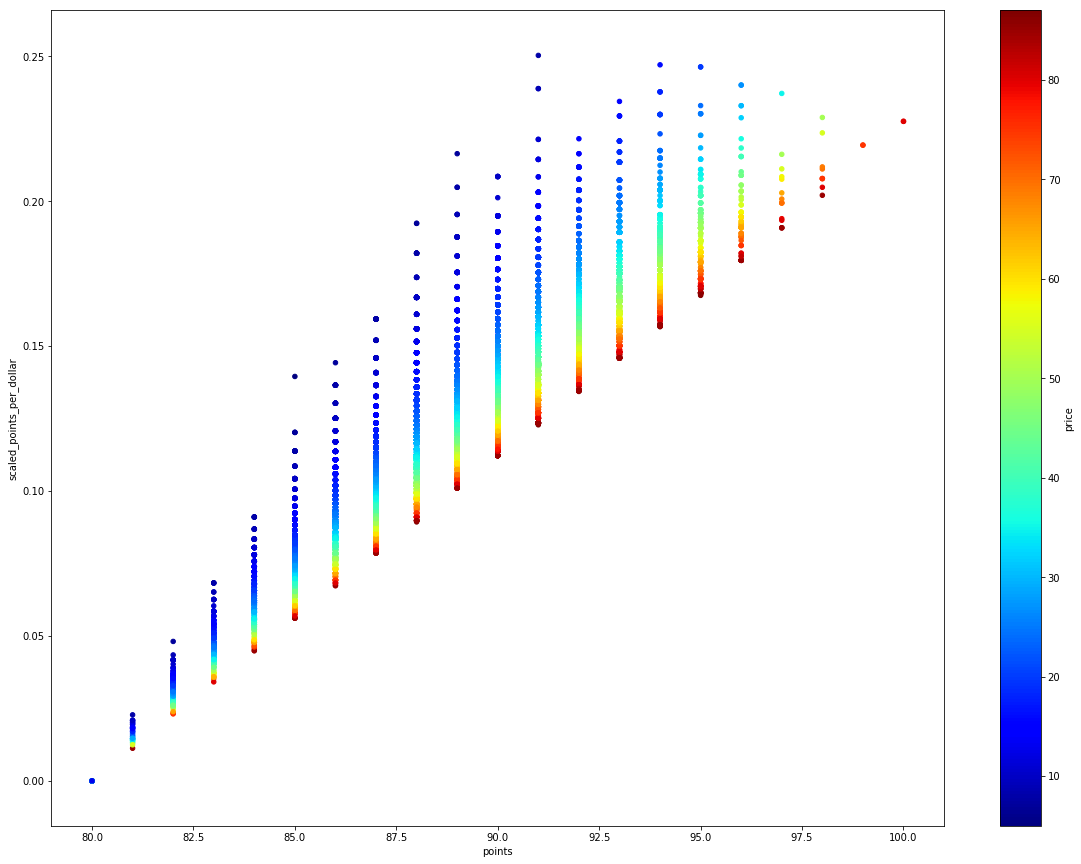

In [37]:
wine.plot.scatter(y='scaled_points_per_dollar', x='price', c='points', colormap='jet', figsize=(20,15), sharex=False)
plt.show()

wine.plot.scatter(y='scaled_points_per_dollar', x='points', c='price', colormap='jet', figsize=(20,15), sharex=False)
plt.show()

### Country

### Variety

### Winery

## Regression model to predict price and then flag wines that have prices lower than expected

In [41]:
wine[cat_var].shape

(19202, 6)

In [18]:
cat_var = ['designation', 'province', 'region_1', 'region_2', 'variety', 'winery']
pd.get_dummies(wine[cat_var]).head()

,designation_#19 Phantom Limb Belmont Vineyard,designation_&,designation_'Blend 105' Red Wine,designation_'S',designation_'Unfiltered',designation_'Vie!',designation_*%#&@!,designation_0.5 Brix,designation_1,designation_100% Skin Fermented,...,winery_ded.reckoning,winery_iNapa Wine,winery_j.brix,winery_kukkula,winery_pb,winery_un4seen,winery_Écluse,winery_Élevée Winegrowers,winery_Órale,winery_àMaurice
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# from sklearn.neighbors import KNeighborsRegressor
# y = wine['price']
# # X = wine.drop(['price'] , axis=1)
# X = pd.get_dummies(wine[cat_var + ['points']])
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# knn = KNeighborsRegressor(n_neighbors=10)

# # fitting the model
# knn.fit(X_train, y_train)

# # predict the response
# pred = knn.predict(X_test)

# # evaluate accuracy
# print (accuracy_score(y_test, pred))

# Variation between raters

+ Do raters rate the same wines differently? 
+ Do some raters have systematic biases towards specific countries, wineries, or varieties?

# Reverse-engineer descriptions of top wines

Use a naive bases binomial classifier to work out which words in descriptions are associated with high-scoring wines. We can then construct our own descriptions for high-scoring wines and see what our model would predict the scores to be.

# Preprocess data

In [20]:
y = wine['excellent+']
X = wine.drop('excellent+', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

KeyError: 'excellent+'

# Modelling

In [ ]:
data = wine[['excellent+', 'country', 'variety', 'year']]
data = pd.get_dummies(data, columns = ['country', 'variety'])

X = data.drop('excellent+', axis = 1)
y = data['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegressionCV(random_state = 0, cv = 10)

X_train.shape
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(classifier.fit(X_train, y_train), prefit = True)
X_train_selected = model.transform(X_train)
X_train_selected.shape
X_test_selected = X_test.loc[:, model.get_support()]

# clf = Pipeline([
#   ('feature_selection', SelectFromModel(LogisticRegressionCV(random_state = 0, cv = 10))),
#   ('classification', LogisticRegressionCV())
# ])
# clf.fit(X_train, y_train)
classifier = LogisticRegression(random_state = 0)
y_pred = cross_val_predict(classifier, X_test_selected, y_test, cv = 10)
y_pred_probs = cross_val_predict(classifier, X_test_selected, y_test, cv = 10, method='predict_proba')

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))


In [ ]:
data = wine[['excellent+', 'log_price', 'country', 'variety', 'year']]
data = pd.get_dummies(data, columns = ['country', 'variety'])

X = data.drop('excellent+', axis = 1)
y = data['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegression(random_state = 0)
y_pred = cross_val_predict(classifier, X_train, y_train, cv = 10)
y_pred_probs = cross_val_predict(classifier, X_train, y_train, cv = 10, method='predict_proba')

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))

# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# y_pred_proba = classifier.predict_proba(X_test)

# print(confusion_matrix(y_test, y_pred))
# print(metrics.classification_report(y_test, y_pred))
# print(metrics.accuracy_score(y_test, y_pred))
# print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))


In [ ]:
model = classifier.fit(X_train, y_train)
exp_coef = pd.DataFrame({'exp_coef': np.exp(model.coef_[0])}, index = X.columns).sort_values('exp_coef', ascending = 0)
exp_coef.head(10)          
exp_coef.tail(10) 

In [ ]:
data2 = wine[['excellent+', 'log_price']]

X2 = data2.drop('excellent+', axis = 1)
y = data2['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegression(random_state = 0)
y_pred2 = cross_val_predict(classifier, X2, y, cv = 10)
y_pred_probs2 = cross_val_predict(classifier, X2, y, cv = 10, method='predict_proba')
classifier.fit(X_train, y_train)
# y_pred_probs = classifier.predict(X_test)

print(confusion_matrix(y, y_pred2))
print(metrics.classification_report(y, y_pred2))
print(metrics.accuracy_score(y, y_pred2))
print(metrics.roc_auc_score(y, y_pred_probs2[:, 1]))

## Use wine description to predict score

In [11]:
# Compute word counts
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['description'])
X_test_vec = vectorizer.transform(X_test['description'])

             precision    recall  f1-score   support

          0       0.86      0.82      0.84     60658
          1       0.72      0.78      0.75     36820

avg / total       0.81      0.80      0.81     97478

Area under ROC: 0.882017501387


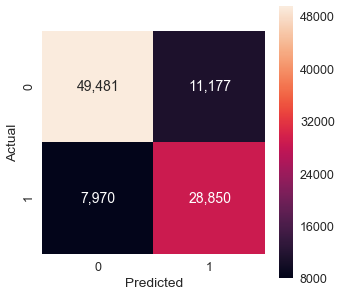

In [12]:
# Fit a naive bayes model to the training data.
nb_classifier = MultinomialNB()
model_results_cv(X_train_vec, y_train, nb_classifier)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

             precision    recall  f1-score   support

          0       0.86      0.82      0.84     20268
          1       0.72      0.79      0.75     12225

avg / total       0.81      0.81      0.81     32493

Area under ROC: 0.883305043703


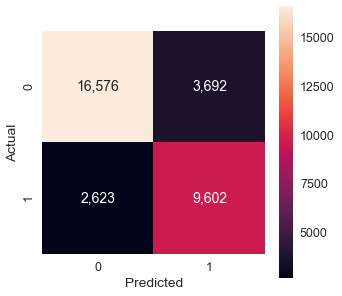

In [13]:
nb_classifier.fit(X_train_vec, y_train)
y_predict = nb_classifier.predict(X_test_vec)
y_predict_proba = nb_classifier.predict_proba(X_test_vec)
model_results(y_test, y_predict, y_predict_proba)

In [38]:
pd.DataFrame({'y_predict': y_predict, 
              'y_predict_proba': y_predict_proba[:, 0]})

,y_predict,y_predict_proba
0,0,1.000000e+00
1,1,1.044344e-02
2,0,9.983053e-01
3,1,4.211216e-01
4,0,9.501149e-01
5,0,9.998989e-01
6,0,9.756564e-01
7,0,8.304256e-01
8,0,7.174586e-01
9,0,9.997202e-01


In [53]:
y_test.head()

70354     0
4473      1
59653     0
107856    1
64547     0
Name: excellent+, dtype: int64

In [15]:
incorrectly_classified_idx = (y_test != y_predict).tolist()
incorrectly_classified = pd.concat([X_test.reset_index(), 
                                    y_test.reset_index(),
                                   pd.DataFrame({'y_predict': y_predict,
                                                 'y_predict_proba': y_predict_proba[:, 1]})],
                                  axis = 1)[incorrectly_classified_idx]

In [ ]:
incorrectly_classified.head()